## In this activity, we will use Argovis to explore temperature fields that were created from observations: our goal is to describe the differences between different phases of ENSO

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll use the Argovis API to access temperature fields and describe different phases of ENSO.

> **This is a beta product!**
> Argovis' new API is currently undergoing heavy development. Therefore, everything in these notebooks should be understood as a technical preview only; implementation details may change before a 
stable release is made. Please send feedback and ideas to argovis@colorado.edu, and see the API docs as they evolve at https://argovis-api.colorado.edu/docs/.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import requests, xarray, pandas, math, datetime, copy
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import matplotlib.pyplot as plt
from scipy import signal

import urllib

from grids_helper import def_activity_param, run_activity_maps, \
                        run_activity_sections, plot_line_pos_neg,\
                        query_grid_by_region_month_year, \
                        create_boxstr_for_query, \
                        areaweighted_region_mean

API_KEY=''
API_PREFIX = 'https://argovisbeta01.colorado.edu/api/'

In [2]:
# %%javascript
# IPython.OutputArea.auto_scroll_threshold = 9999

## Accessing gridded fields in Argovis

Argovis supports a number of grids through the same API endpoints. Let's begin by discovering what grids are available:

In [3]:
grids = avh.query('grids/vocabulary', options={'parameter':'gridName'}, apikey=API_KEY, apiroot=API_PREFIX)
grids

[{'grid_1_1_0.5_0.5': {'grids': ['rg09_temperature',
    'rg09_salinity',
    'kg21_ohc15to300'],
   'lattice': [[-179.5, -64.5],
    [-179.5, -63.5],
    [-179.5, -62.5],
    [-179.5, -61.5],
    [-179.5, -60.5],
    [-179.5, -59.5],
    [-179.5, -58.5],
    [-179.5, -57.5],
    [-179.5, -56.5],
    [-179.5, -55.5],
    [-179.5, -54.5],
    [-179.5, -53.5],
    [-179.5, -52.5],
    [-179.5, -51.5],
    [-179.5, -50.5],
    [-179.5, -49.5],
    [-179.5, -48.5],
    [-179.5, -47.5],
    [-179.5, -46.5],
    [-179.5, -45.5],
    [-179.5, -44.5],
    [-179.5, -43.5],
    [-179.5, -42.5],
    [-179.5, -41.5],
    [-179.5, -40.5],
    [-179.5, -39.5],
    [-179.5, -38.5],
    [-179.5, -37.5],
    [-179.5, -36.5],
    [-179.5, -35.5],
    [-179.5, -34.5],
    [-179.5, -33.5],
    [-179.5, -32.5],
    [-179.5, -31.5],
    [-179.5, -30.5],
    [-179.5, -29.5],
    [-179.5, -28.5],
    [-179.5, -27.5],
    [-179.5, -26.5],
    [-179.5, -25.5],
    [-179.5, -24.5],
    [-179.5, -23.5],
    [-179

In the following, we will use the temperature product by Roemmich and Gilson, 2009, i.e. temperature_rg. This product was created mapping mesurements from Argo profiles.

### Test

The code below takes several minutes to get the data from Argovis. 

In [6]:
# 150.5,-119.5,-3,3
latitude_south_index = -5
latitude_north_index = 3

longitude_west_index = 150
longitude_east_index = -150

levels_index    = '0,2000' # '290,310' # '0,5'

In [7]:
data = query_grid_by_region_month_year( lattice_name='grid_1_1_0.5_0.5',\
                                        grid_name='rg09_temperature',\
                                        region_str = create_boxstr_for_query(longitude_west=longitude_west_index,\
                                                                             longitude_east=longitude_east_index, \
                                                                             latitude_south=latitude_south_index,\
                                                                             latitude_north=latitude_north_index), \
                                        long_conversion_type='long20_380',\
                                        levels=levels_index,\
                                        month_start=1,year_start=2004,\
                                        month_end=12,year_end=2021,\
                                        API_KEY=API_KEY,API_PREFIX=API_PREFIX)

In [8]:
# compute anomalies
#data_reg_ave = areaweighted_region_mean(dxr=data.mean(dim="pressure"))
data_reg_ave_detrend = data
#data_reg_ave_detrend = data_reg_ave*0 + signal.detrend(data_reg_ave["data"])
climatology = data_reg_ave_detrend.groupby("time.month").mean("time")
data_reg_ave_anom   = data_reg_ave_detrend.groupby("time.month") - climatology

In [9]:
def areaweighted_region_mean(dxr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.latitude))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean(("longitude", "latitude"))

In [10]:
d2pl = areaweighted_region_mean(dxr=data_reg_ave_anom)

In [11]:
d2pl

<xarray.Dataset>
Dimensions:   (time: 216, pressure: 58)
Coordinates:
  * time      (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2021-12-15
  * pressure  (pressure) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    data      (time, pressure) float64 0.3696 0.3696 ... -0.006685 -0.003286

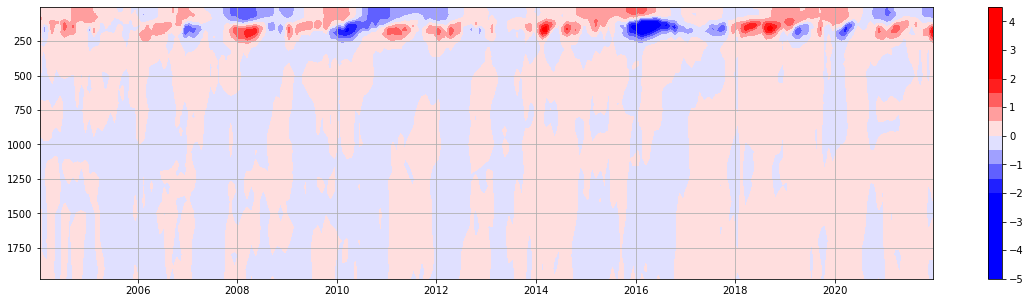

In [12]:
plt.figure(figsize=(20,5))
plt.contourf(d2pl['time'].values,d2pl['pressure'].values,d2pl['data'].transpose(),np.arange(-5,5,.5),vmin=-2,vmax=2,cmap='bwr')
plt.gca().invert_yaxis()
plt.colorbar()
plt.grid()
plt.show()